In [5]:
import sys
sys.path.append('../')
from config_sing import *
show_env()

You are in: Singularity | singularity_proj_combeffect
    BASE DIRECTORY:     /mount/work
    PATH OF SOURCE:     /mount/work/source
    PATH OF EXECUTABLE: /mount/work/exe
    PATH OF ANNOTATION: /mount/work/annotation
    PATH OF PROJECT:    /mount/project
    PATH OF RESULTS:    /mount/work/out/proj_combeffect

Library imported:
    numpy, pandas, matplotlib.pyplot
    os, sys, time, gzip, glob



In [63]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
import xgboost as xgb
import shap
import json

In [89]:
from functools import partial, reduce
print = partial(print, flush=True)

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT    = reduce(fun, ["Input", idx])
INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])

In [105]:
from collections import Counter

In [100]:
def read_data(sample):
    fdiry = os.path.join(FD_RES, "scratch", "region_dex_GR_P300_dnase_chr17")
    fname = f"{sample}_motif_count.tsv"
    fpath = os.path.join(fdiry, fname)
    dat   = pd.read_csv(fpath, sep = "\t", names=["Fragment", "Motif_Count"])
    return dat

In [101]:
fun = read_data
lst = list(map(fun, TFX_DMSO))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_tfx_dmso = dat
print(dat.shape)
dat

(10802, 2)


,Fragment,Motif_Count
0,chr17_6001570_6002624,"{""HD/23"": 1, ""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF..."
1,chr17_6001571_6002624,"{""SOX/1"": 2, ""EVI1/MECOM"": 1, ""ZNF768"": 1, ""NF..."
2,chr17_6001762_6002691,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
3,chr17_6001762_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
4,chr17_6001763_6002692,"{""ZNF549"": 2, ""FEZF1"": 2, ""GCM"": 1, ""SIX/1"": 1..."
...,...,...
2606,chr17_82268021_82268899,"{""NR/4"": 1, ""E2F/2"": 2, ""ZFX"": 2, ""NR/3"": 4, ""..."
2607,chr17_82268031_82268998,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."
2608,chr17_82268031_82268999,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."
2609,chr17_82268032_82268997,"{""Ebox/CAGATGG"": 3, ""ZNF768"": 3, ""Ebox/CAGCTG""..."


In [102]:
fun = read_data
lst = list(map(fun, TFX_DEX))

fun = lambda df1, df2: pd.concat([df1, df2])
dat = reduce(fun, lst)

### assign and show
dat_tfx_dex = dat
print(dat.shape)
dat

(39176, 2)


,Fragment,Motif_Count
0,chr17_6001786_6002741,"{""SIX/1"": 1, ""HIC/1"": 3, ""P53-like/1"": 2, ""GC-..."
1,chr17_6001796_6002785,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
2,chr17_6001796_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
3,chr17_6001797_6002783,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
4,chr17_6001797_6002786,"{""HIC/1"": 3, ""P53-like/1"": 2, ""GC-tract"": 6, ""..."
...,...,...
11873,chr17_82267754_82268685,"{""MAF"": 1, ""Ebox/CAGATGG"": 4, ""ZNF320"": 2, ""GC..."
11874,chr17_82267762_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN..."
11875,chr17_82267763_82268716,"{""ZNF320"": 2, ""GC-tract"": 6, ""SMARCA5"": 2, ""ZN..."
11876,chr17_82267768_82268716,"{""SMARCA5"": 2, ""ZNF143"": 1, ""ZNF134"": 2, ""INSM..."


In [106]:
lst = dat_tfx_dmso["Motif_Count"].to_list() + dat_tfx_dex["Motif_Count"].to_list()
lst = list(map(json.loads, lst))
dat = pd.DataFrame.from_dict(lst).fillna(0)
dat

,HD/23,SOX/1,EVI1/MECOM,ZNF768,NFY,EBF1,GC-tract,ZNF320,CTCF,KLF/SP/2,...,HSFY2,NR/4,ZNF713,TATA,AHR,ARI5B,GMEB2/1,ZBTB14,GMEB2/2,KAISO
0,1.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,1.0,1.0,1.0,1.0,8.0,2.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49973,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49974,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49975,0.0,1.0,0.0,4.0,0.0,1.0,6.0,2.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49976,0.0,1.0,0.0,4.0,0.0,1.0,5.0,1.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
ftr = dat.columns.values
X   = dat #.values
y   = np.r_[np.repeat(0, dat_tfx_dmso.shape[0]), np.repeat(1, dat_tfx_dex.shape[0])]

print(type(X),   X.shape)
print(type(y),   y.shape)
print(type(ftr), ftr.shape)
Counter(y)

<class 'pandas.core.frame.DataFrame'> (49978, 269)
<class 'numpy.ndarray'> (49978,)
<class 'numpy.ndarray'> (269,)


Counter({0: 10802, 1: 39176})

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [109]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(); print(model)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)


In [110]:
y_expc = y_test
y_pred = model.predict(X_test)

print(metrics.classification_report(y_expc, y_pred))
print(metrics.confusion_matrix(y_expc, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.22      0.34      2701
           1       0.82      0.98      0.89      9794

    accuracy                           0.81     12495
   macro avg       0.78      0.60      0.61     12495
weighted avg       0.80      0.81      0.77     12495

[[ 589 2112]
 [ 209 9585]]


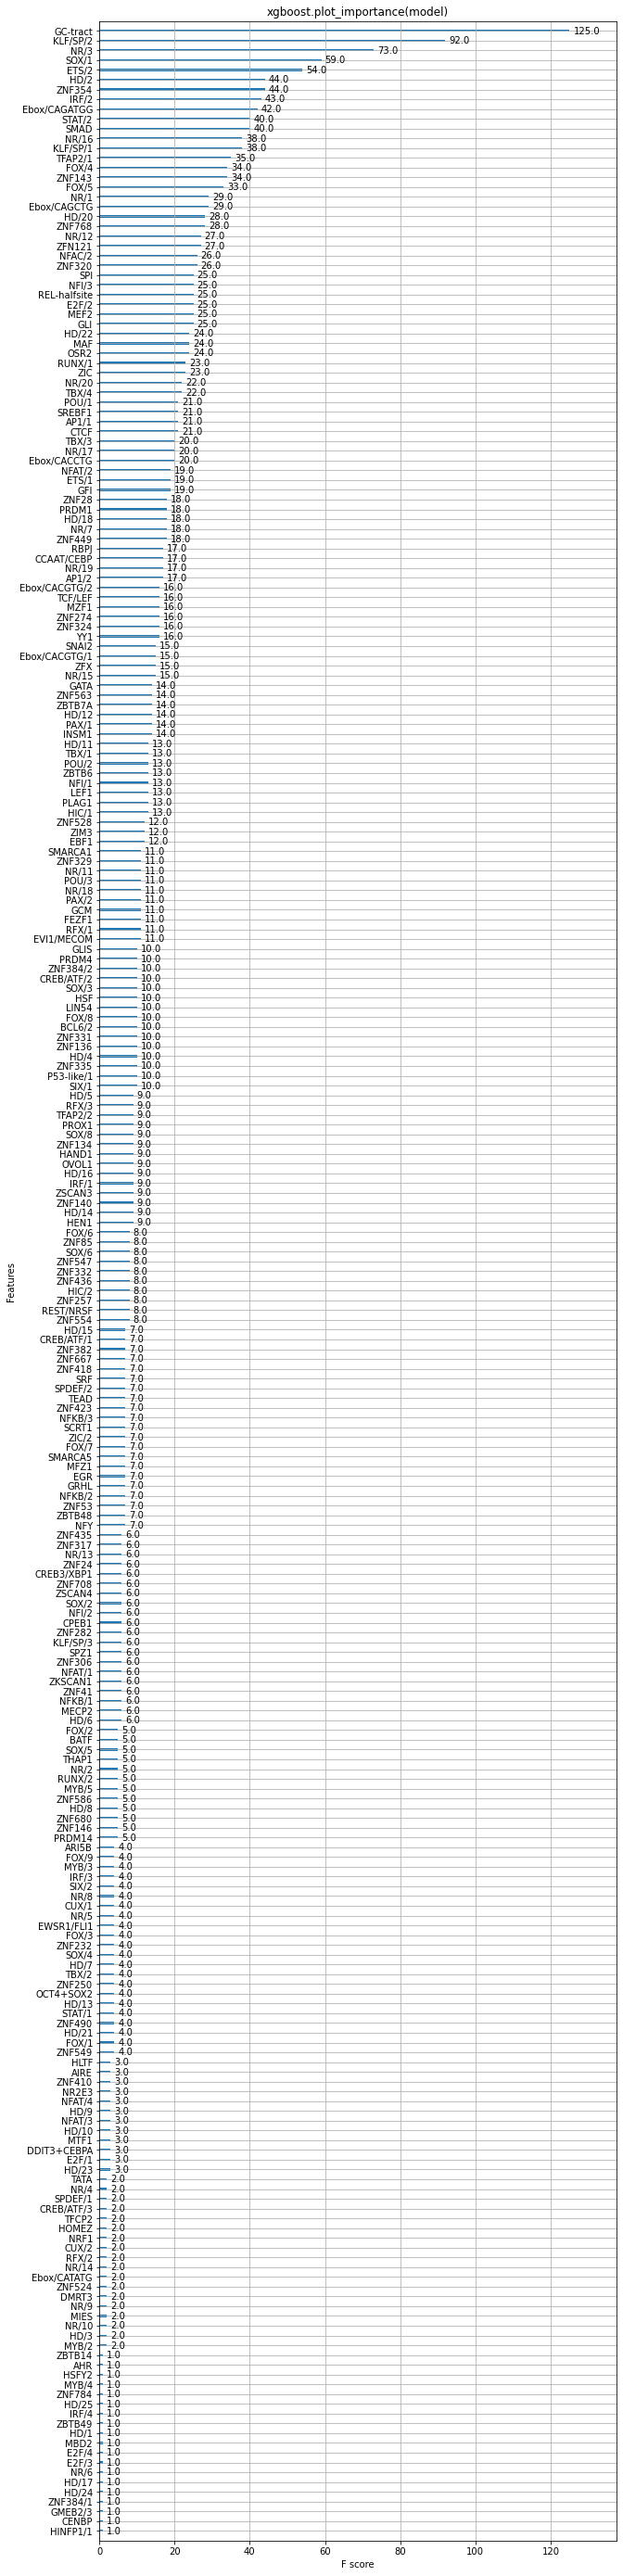

In [111]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 50))
xgb.plot_importance(model, ax = ax)
ax.set_title("xgboost.plot_importance(model)")
plt.show()

In [112]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
print(shap_values.shape)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(12495, 269)


In [115]:
len(ftr)

269

In [116]:
idx = dat.columns.values
shap.bar_plot(
    shap_values,
    feature_names=ftr,
    max_display=20)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()